# Введение


Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений. «В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. Нужно разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Цель проекта
Разработать и внедрить систему персонализированных предложений для постоянных клиентов интернет-магазина "В один клик" с целью удержания активности постоянных клиентов и увеличения их покупательской активности.

Этапы проекта:
1. Загрузка и изучение данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение таблиц
5. Корреляционный анализ
6. Использование пафпланов
7. Анализ важности признаков
8. Сегментация покупателей

In [42]:
!pip install -U scikit-learn -q
!pip install shap -q


##  Загрузка данных

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import shapiro
import statistics
from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import shap

import transformers

In [44]:
def create_boxplot_and_hist(data, columns):
    for i in data[columns].columns:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
        axes[0].hist(data[i], bins=30)
        axes[0].set_title('Гистограмма распределения')
        axes[0].set_xlabel(i)

        axes[1].boxplot(data[i])
        axes[1].set_xlabel(i)
        axes[1].set_title('Ящик с усами')
        plt.show()

In [45]:
market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal=',')

In [46]:
display(market_file.head(5))
display(market_money.head(5))
display(market_time.head(5))
display(money.head(5))

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [47]:
market_file.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Пропусков в таблицах не обнаружено

## Предобработка данных

In [48]:
#проверяем дубликаты
display(market_file.duplicated().sum())
display(market_money.duplicated().sum())
display(market_time.duplicated().sum())
display(money.duplicated().sum())

0

0

0

0

In [49]:
def duplicates(columns, data):
    for column in columns:
        unique_values = data[column].unique()
        print(f'Уникальные значения в колонке {column}: {unique_values}')


print('market_file')
columns = ['Покупательская активность', 'Тип сервиса', 'Популярная_категория', ]
duplicates(columns, market_file)
print()
print('money')
columns = ['Период']
duplicates(columns, market_money)
print()
print('market_time')
duplicates(columns, market_time)

market_file
Уникальные значения в колонке Покупательская активность: ['Снизилась' 'Прежний уровень']
Уникальные значения в колонке Тип сервиса: ['премиум' 'стандартт' 'стандарт']
Уникальные значения в колонке Популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

money
Уникальные значения в колонке Период: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

market_time
Уникальные значения в колонке Период: ['текущий_месяц' 'предыдцщий_месяц']


In [50]:
market_file = market_file.replace('стандартт', 'стандарт')
market_time = market_time.replace('предыдцщий_месяц', 'предыдущий_месяц')

* Явных дубликатов не обнаружено
* Были найдены и исправлены неявные дубликаты

## Исследовательский анализ данных

### Статистический анализ market_file

In [51]:
#создадим переменные с количественными и категориальными признаками
cat_market_file = market_file.select_dtypes(exclude='number').columns.tolist()
num_market_file = market_file.select_dtypes(include='number').columns.tolist()

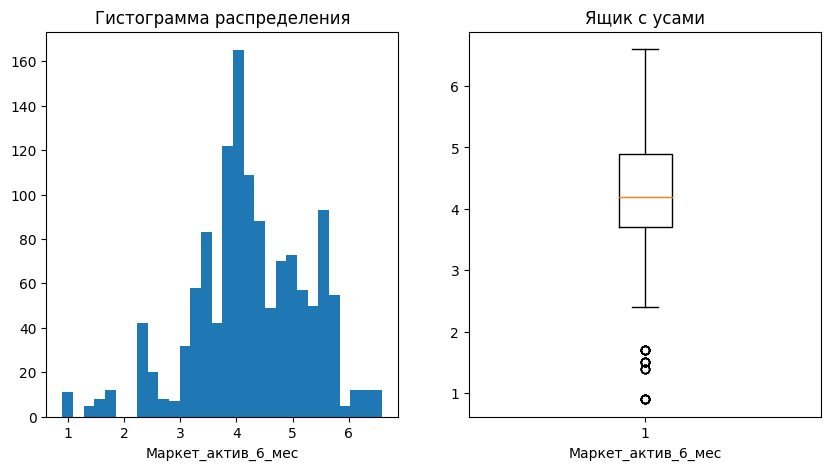

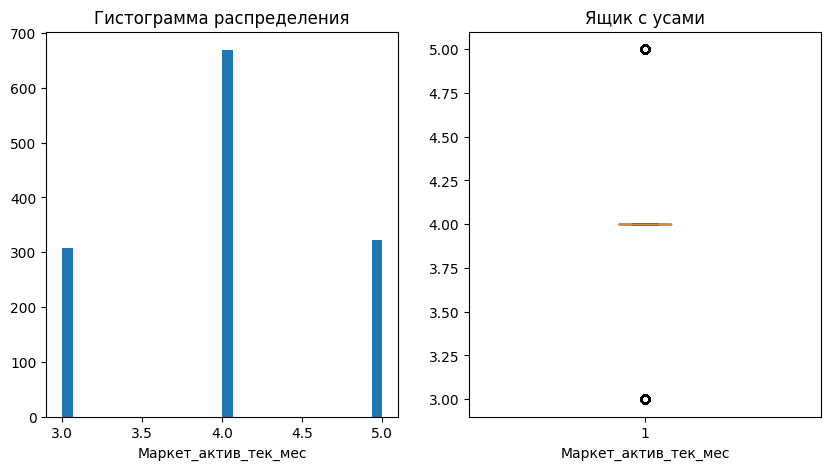

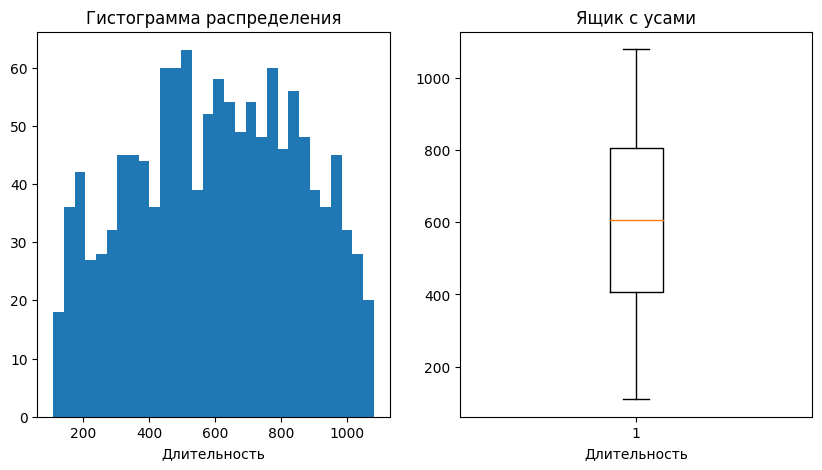

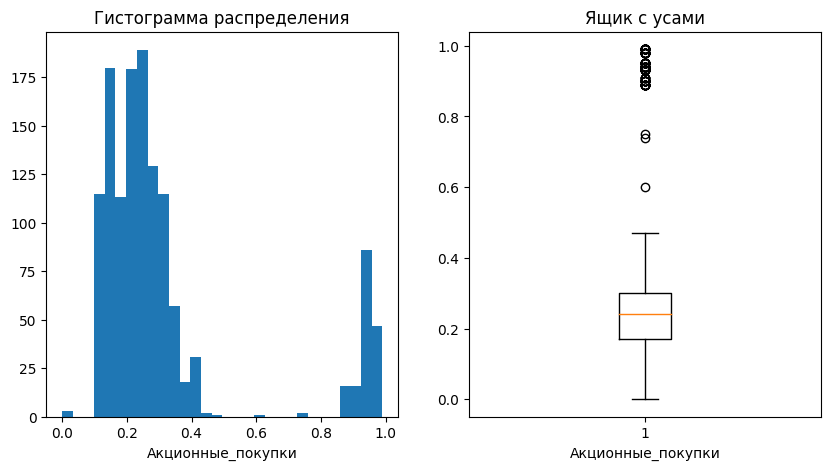

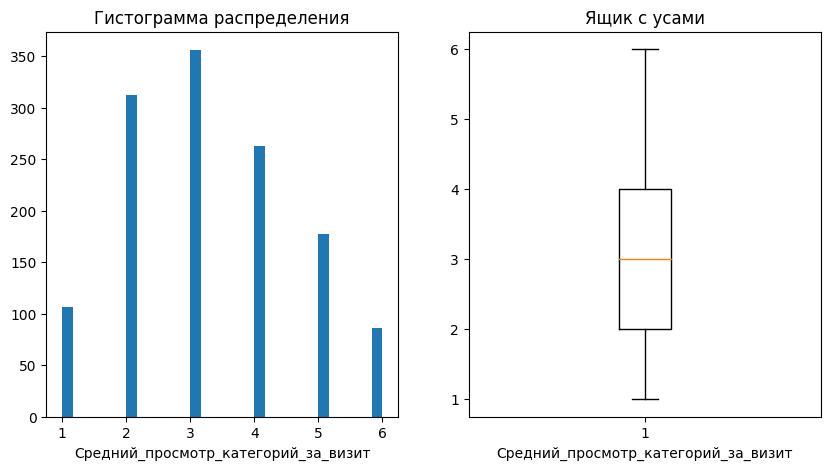

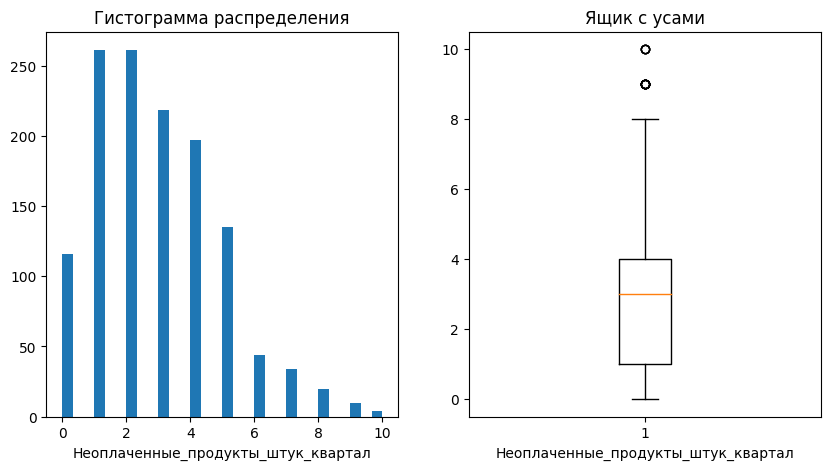

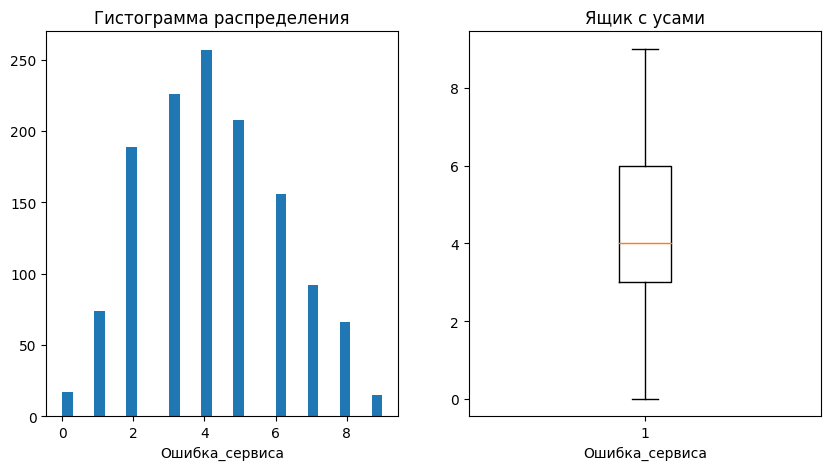

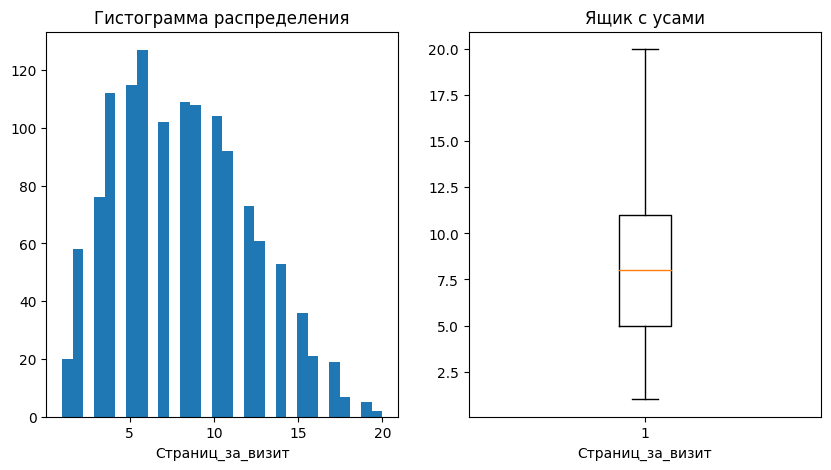

In [52]:
create_boxplot_and_hist(market_file, num_market_file[1:9])

По графикам видно:
1. В среднем по 4 маркетинговых коммуникаций компании, приходилось на покупателя за последние 6 месяцев
2. Чаще всего рассылалось по 4 маркетинговых коммуникаций в текущем месяце, минимум - 3, максимум - 5
3. Длительность регистрации покупателей на сайте от ~50 до 1100 дней
4. Обычно доля акционных покупок клиентов составляет 0.1 - 0.3, но небольшое количество клиентов закупаются только по акции
5. В среднем происходит по 4 ошибки у покупателя во время посещения сайта


Выбросы выглядят вполне нормальными, поэтому удалять их не будем

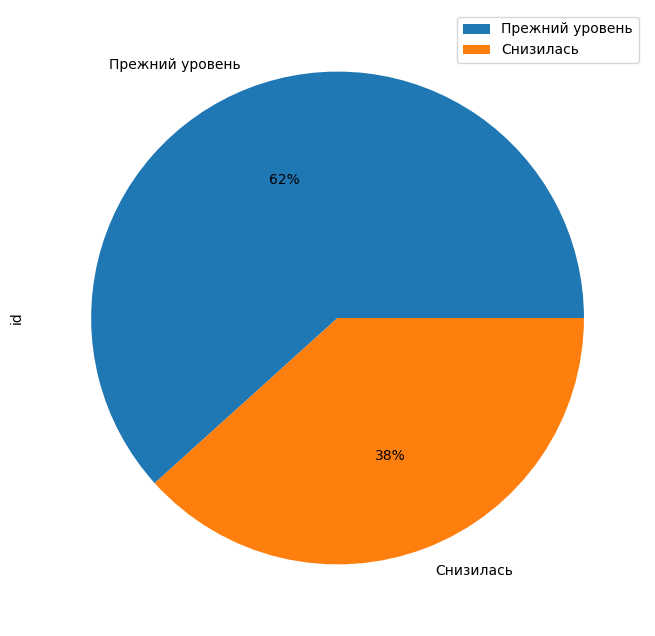

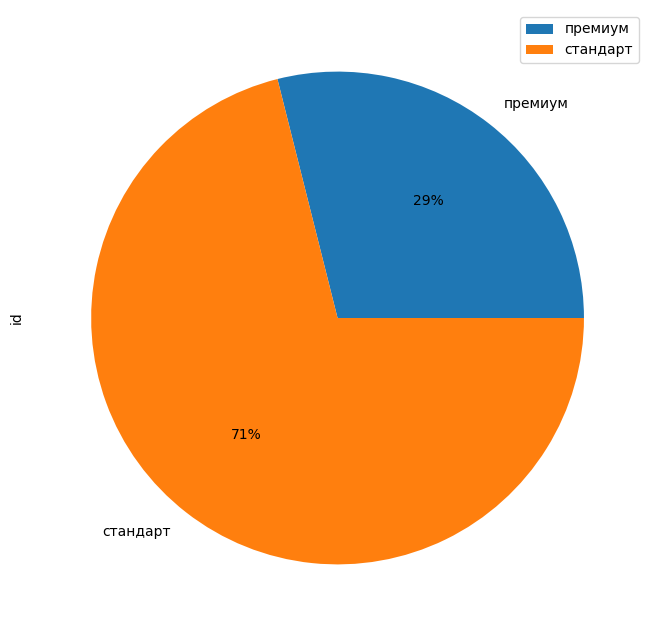

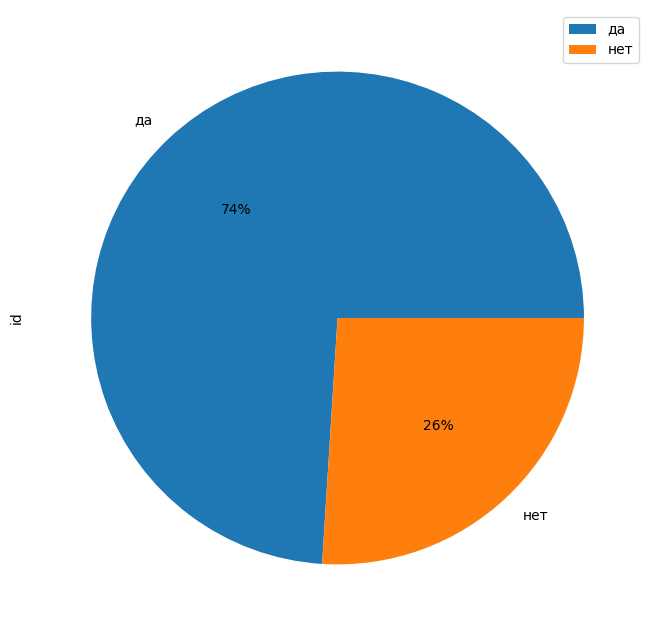

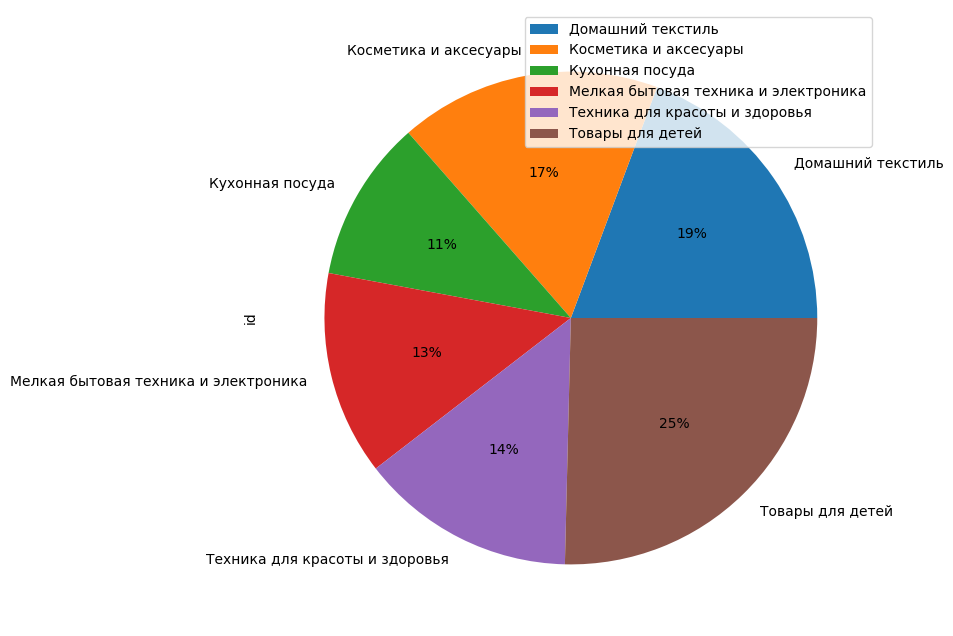

In [53]:
#построим графики, которые покажут в какой пропорции мы имеем категориальные признаки

for column in market_file[cat_market_file].columns:
    market_file.groupby(column).count().plot(kind='pie', y='id', autopct='%1.0f%%', figsize=(8,8))

По графикам видно:
1. у 38% покупателей снизилась покупательская активность
2. Премиум подписка есть у 29% покупателей
3. 3/4 покупателей дают согласие на рассылку дополнительного предложения о товаре
4. Популярность категорий распределена равномерно, только Товары для детей являются более популярной категорией

### Статистический анализ market_money

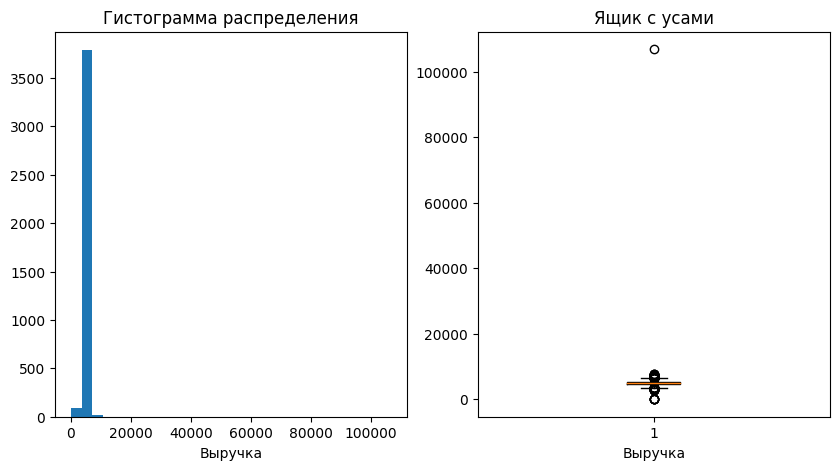

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(market_money['Выручка'], bins=30)
axes[0].set_title('Гистограмма распределения')
axes[0].set_xlabel('Выручка')

axes[1].boxplot(market_money['Выручка'])
axes[1].set_xlabel('Выручка')
axes[1].set_title('Ящик с усами')
plt.show()

Удалим явный выброс

<Axes: >

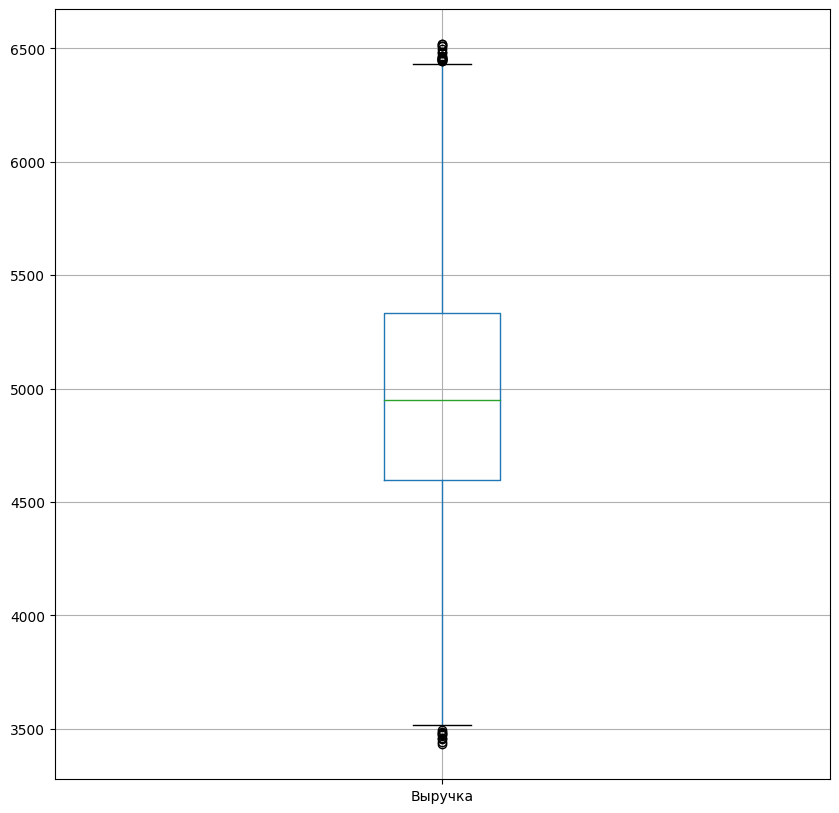

In [56]:
#market_money = market_money[(market_money['Выручка'] <= 7000) &  (market_money['Выручка'] >= 3500)]

#удалим выбросы
Q1 =  market_money['Выручка'].quantile(0.25)
Q3 =  market_money['Выручка'].quantile(0.75)
IQR = Q3 - Q1

market_money = market_money[(market_money['Выручка'] > (Q1-1.5*IQR)) & (market_money['Выручка'] < (Q3+1.5*IQR))]
market_money.boxplot(column="Выручка")

### Статистический анализ market_time

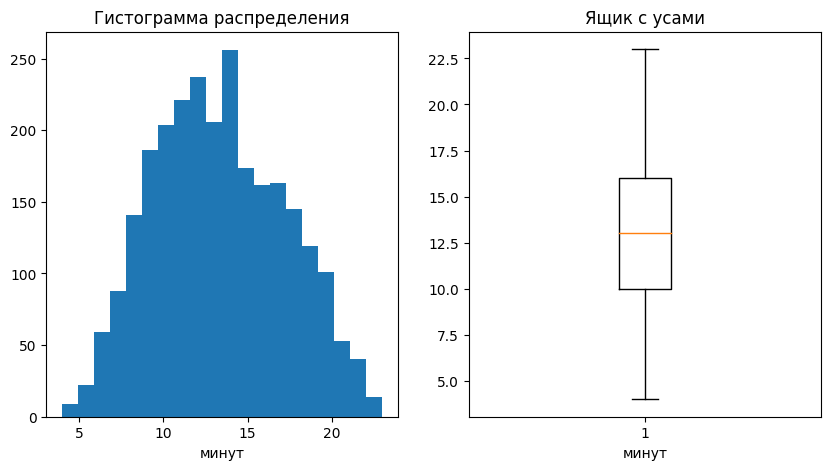

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(market_time['минут'], bins=20)
axes[0].set_title('Гистограмма распределения')
axes[0].set_xlabel('минут')

axes[1].boxplot(market_time['минут'])
axes[1].set_xlabel('минут')
axes[1].set_title('Ящик с усами')
plt.show()

Создадим сводную таблицу по каждому клиенту и отберем тех, кто совершал покупки последние 3 месяца

In [58]:
df_pivot = pd.pivot_table(market_money, index='id', columns='Период', values='Выручка').add_prefix('выручка_')
df_pivot = df_pivot[(df_pivot['выручка_предыдущий_месяц'] != 0) & (df_pivot['выручка_препредыдущий_месяц'] != 0)].reset_index()

Провели статистичесаий анализ данных датафреймов, удалили выбросы и отборали клиентов с покупательской активностью не менее трёх месяцев

In [59]:
df_pivot

Период,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,NaN
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5
...,...,...,...,...
1294,216643,3664.0,4704.0,4741.7
1295,216644,4729.0,5299.0,5353.0
1296,216645,5160.0,5334.0,5139.2
1297,216646,4923.0,4725.0,5224.6


## Объединение таблиц

In [60]:
df_pivot_1 = pd.pivot_table(market_time, index='id', columns='Период', values='минут').add_prefix('минут_').reset_index()

In [61]:
df_merged = market_file.merge(df_pivot)
df_merged = df_merged.merge(df_pivot_1)
#df_merged = df_merged.drop('id', axis=1)
df_merged

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,NaN,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1295,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1296,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1297,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


In [62]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1299 non-null   int64  
 1   Покупательская активность            1299 non-null   object 
 2   Тип сервиса                          1299 non-null   object 
 3   Разрешить сообщать                   1299 non-null   object 
 4   Маркет_актив_6_мес                   1299 non-null   float64
 5   Маркет_актив_тек_мес                 1299 non-null   int64  
 6   Длительность                         1299 non-null   int64  
 7   Акционные_покупки                    1299 non-null   float64
 8   Популярная_категория                 1299 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1299 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1299 non-null   int64  
 11  Ошибка_сервиса                

In [63]:
df_merged.isna().sum()

id                                       0
Покупательская активность                0
Тип сервиса                              0
Разрешить сообщать                       0
Маркет_актив_6_мес                       0
Маркет_актив_тек_мес                     0
Длительность                             0
Акционные_покупки                        0
Популярная_категория                     0
Средний_просмотр_категорий_за_визит      0
Неоплаченные_продукты_штук_квартал       0
Ошибка_сервиса                           0
Страниц_за_визит                         0
выручка_предыдущий_месяц                46
выручка_препредыдущий_месяц              2
выручка_текущий_месяц                  124
минут_предыдущий_месяц                   0
минут_текущий_месяц                      0
dtype: int64

In [64]:
df_merged = df_merged.dropna()
df_merged.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
выручка_предыдущий_месяц               0
выручка_препредыдущий_месяц            0
выручка_текущий_месяц                  0
минут_предыдущий_месяц                 0
минут_текущий_месяц                    0
dtype: int64

Объединили таблицы и удалили клиентов, не имеющих полной покупательской активности

## Корреляционный анализ

Для проведения корреляционного анализа, проверим являются ли данные нормально распределнными. Успользуем для этого тест Шапиро-Уилка

In [65]:
def shapiro_test(data, column):

    statistic, p_value = shapiro(data[column])

    # Печать результата теста
    alpha = 0.05  # Уровень значимости
    print(f'Результат теста Шапиро-Уилка для столбца {column}:')
    print(f'Статистика теста: {statistic}')
    print(f'p-значение: {p_value}')
    if p_value > alpha:
        print('Распределение данных является нормальным.')
    else:
        print('Распределение данных не является нормальным.')

In [66]:
#создадим переменные с количественными и категориальными признаками
cat_market_file = df_merged.select_dtypes(exclude='number').columns.tolist()
num_market_file = df_merged.select_dtypes(include='number').columns.tolist()

for i in df_merged[num_market_file].columns:
    shapiro_test(df_merged, i)
    print()

Результат теста Шапиро-Уилка для столбца id:
Статистика теста: 0.9539715051651001
p-значение: 1.779906562576291e-18
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Маркет_актив_6_мес:
Статистика теста: 0.9780628681182861
p-значение: 3.775547582907102e-12
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Маркет_актив_тек_мес:
Статистика теста: 0.8057587146759033
p-значение: 6.009602944068002e-35
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Длительность:
Статистика теста: 0.9719389081001282
p-значение: 4.331260962950681e-14
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Акционные_покупки:
Статистика теста: 0.6567162871360779
p-значение: 5.43703804158029e-43
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Средний_просмотр_категорий_за_визит:
Статистика теста: 0.9316989183425903
p-значение: 1.930

т.к даннные ненормально распределены - применим медот Спирмана для расчета корреляции

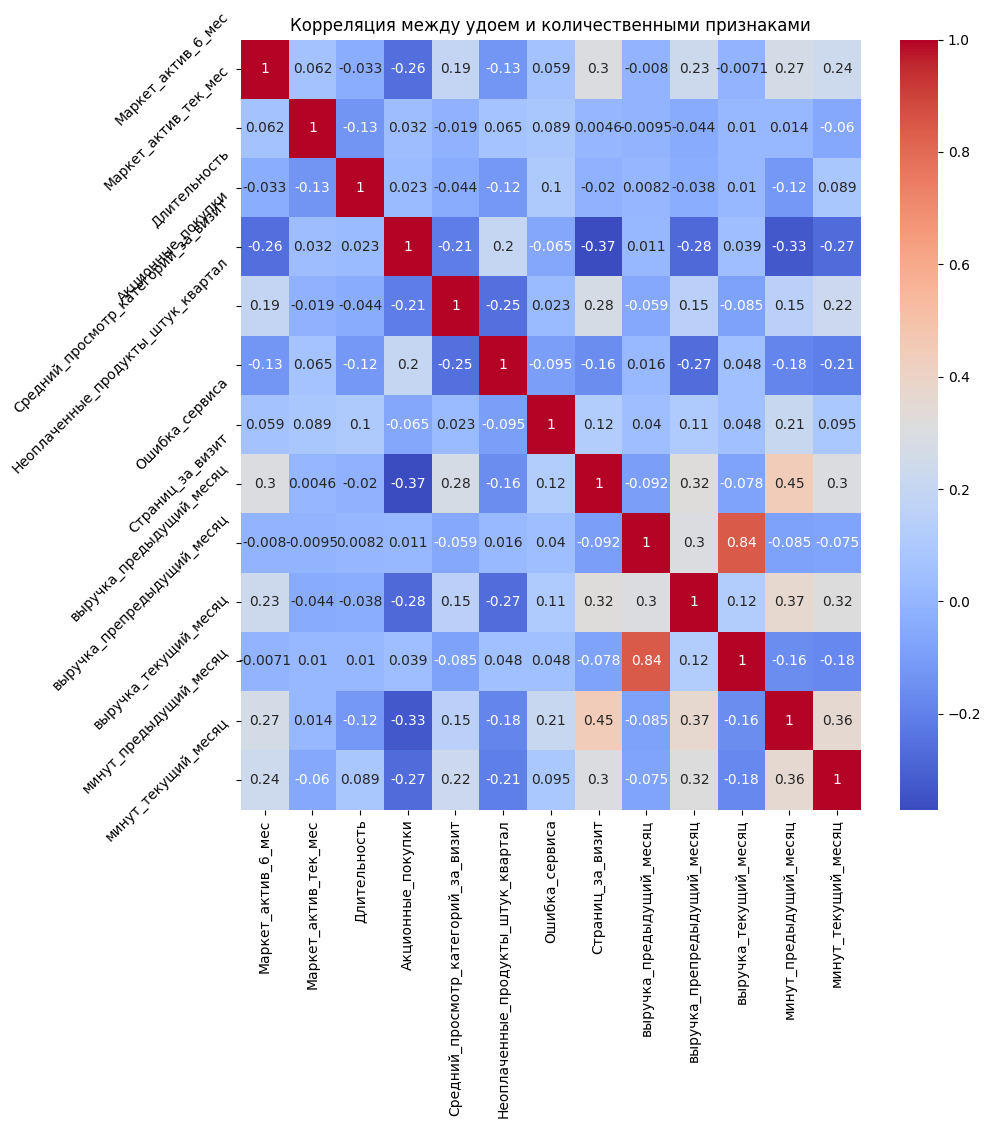

In [67]:
corr_matrix = df_merged[num_market_file[1:14]].corr(method='spearman')

# Построение тепловой карты
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.yticks(rotation=45)
plt.title(f'Корреляция между удоем и количественными признаками')
plt.show()
plt.rcParams["figure.figsize"] = (10,10)

Самая высокая кореляция между выручкой за разные месяцы - 0.88. Нам требуется учесть динамику продаж по месяцам, поэтому оставляем все признаки в работе, считаем, что мультиколлинеартности в данных нет.

## Использование пайплайнов

In [68]:
#заменим целевую переменную на 0 и 1
df_merged['Покупательская активность'] = df_merged['Покупательская активность'].apply(lambda x: 1 if x == 'Снизилась' else 0)

# создание константы RANDOM_STATE
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    df_merged.drop(['Покупательская активность', 'id'], axis=1),
    df_merged['Покупательская активность'],
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify = df_merged['Покупательская активность']
)
#создадим переменные с количественными и категориальными признаками

num_columns = X_train.select_dtypes(include='number').columns.tolist()
#ord_col = ['Тип сервиса']
ohe_columns = X_train.select_dtypes(exclude='number').columns.tolist()
#ohe_columns = ['Разрешить сообщать', 'Популярная_категория']

<ipython-input-68-d554121ac30e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Покупательская активность'] = df_merged['Покупательская активность'].apply(lambda x: 1 if x == 'Снизилась' else 0)


In [69]:
ohe_pipe = Pipeline(
    [
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)


data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [70]:
# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            kernel = 'poly',
            degree = 6
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)


print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

pred = randomized_search.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('num', StandardScaler(),
                                                  ['Маркет_актив_6_мес',
                                                   'Маркет_актив_тек_мес'

**Вывод**

Лучшей моделью была выбрана модель LogisticRegression со следующими параметрами:
- C (параметр регуляризации) равен 1
- Метод отбора признаков - L1-регуляризация
- random_state установлен на 42
- Метрика лучшей модели на тренировочной выборке составляет 0.9045
- Метрика ROC-AUC на тестовой выборке составляет 0.8761, что говорит о хорошей способности модели классифицировать тестовые данные



## Анализ важности признаков

Столбчатая диаграмма shap.plots.bar отражает общий вклад признаков в прогнозы модели. Она показывает средние SHAP-значения признака по всем наблюдениям. Для расчёта средних берут значения Шепли по модулю, чтобы положительные и отрицательные значения не сводили друг друга к нулю.

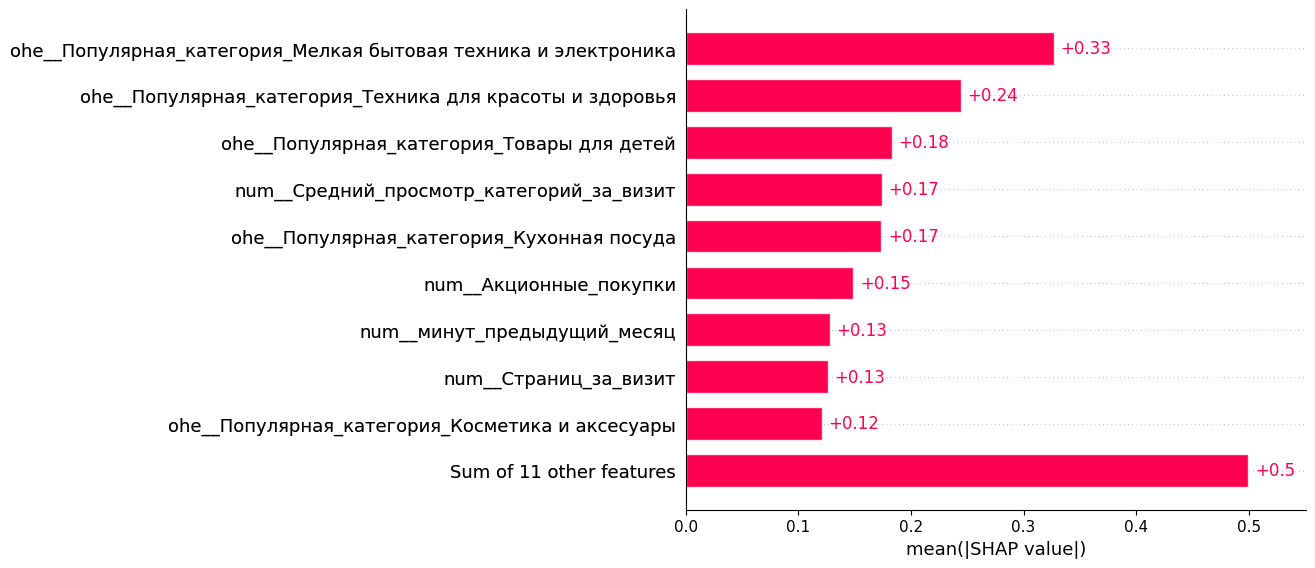

In [71]:
X_train = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'], X_train)

X_test = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test = pd.DataFrame(X_test, columns=feature_names)
shap_values = explainer(X_test)

shap.plots.bar(shap_values)

На сгенерированном датасете самый большой вес у признака 'ohe__Популярная_категория_мелкая техника', он сильнее всего влияет на прогнозы модели.

Диаграмма shap.plots.beeswarm — это один из вариантов визуализации вклада признаков в каждое предсказание модели. На ней точками отображены все наблюдения из выборки.
На оси X отложены значения Шепли, на оси Y — признаки модели, расположенные сверху вниз в порядке убывания средних SHAP‑значений.

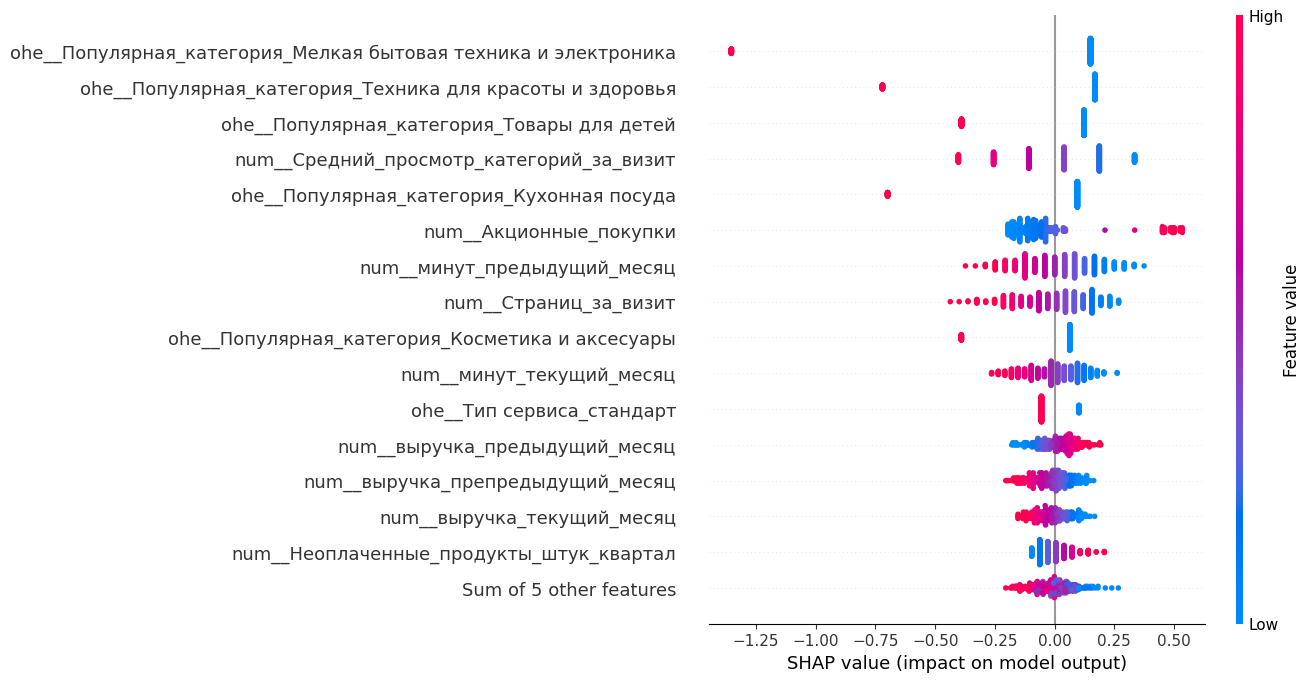

In [72]:
shap.plots.beeswarm(shap_values, max_display=16)

По графику видно:
1. Чем больше значения признака 'ohe__Популярная_категория_мелкая техника', тем меньше SHAP‑значения объектов. Если у наблюдения высокое значение этих признаков, то у него высокая вероятность принадлежности к классу 0(Прежний уровень)



In [73]:
randomized_search.best_estimator_.named_steps['models'].classes_

array([0, 1])

## Сегментация покупателей

Для сегментации покупателей сделаем следующие действия:

1. Произведем фильтрацию данных. В датафрейме money оставим только тех, кто есть в merged
2. Сделаем предсказание вероятностей с помощью обученной модели random_search и добавление результатов в датафрейм segmentation
3. Сделаем построение scatter plot для анализа вероятности снижения и прибыльности
4. После выполним расчет матрицы корреляции и построение тепловой карты корреляции
5. Сделаем присвоение категорий в зависимости

In [74]:
matrix = df_merged.drop(['Покупательская активность', 'id'], axis=1)

money= money[money['id'].isin(df_merged['id'])]
proba = randomized_search.predict_proba(matrix)
segmentation = money.copy()
segmentation['вероятность_снижения'] = proba[:, 0]
segmentation.head()

,id,Прибыль,вероятность_снижения
1,215349,4.16,0.073341
2,215350,3.13,0.497300
4,215352,4.21,0.017477
5,215353,3.95,0.348435
6,215354,3.62,0.160089


<Figure size 1000x600 with 0 Axes>

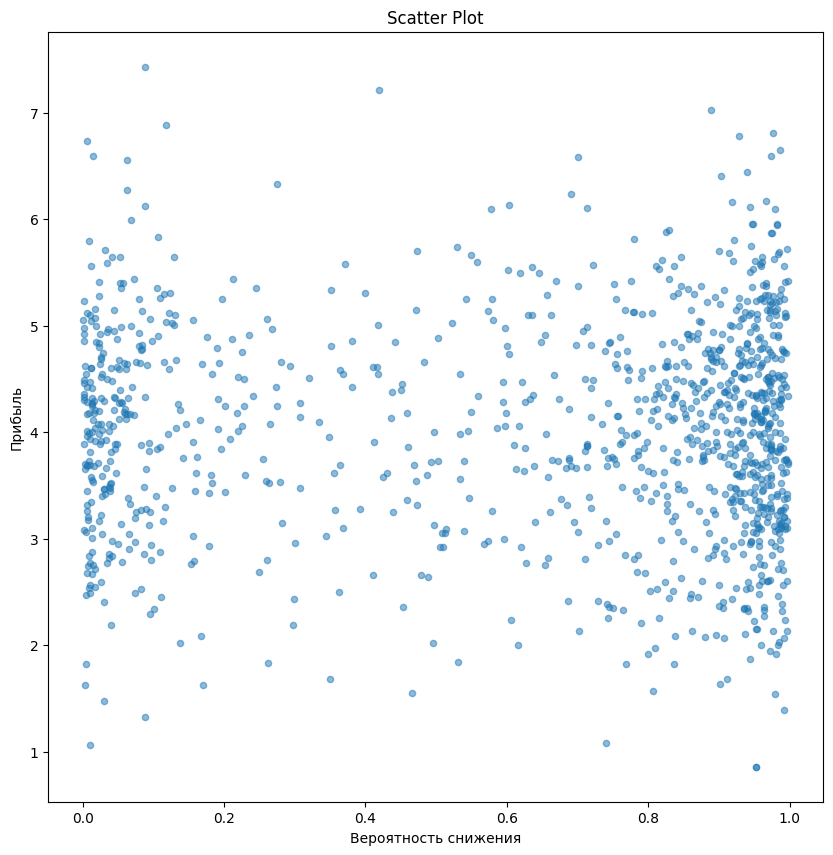

In [75]:
plt.figure(figsize=(10, 6))
segmentation.plot(x='вероятность_снижения', y='Прибыль', kind='scatter', alpha=0.5)
plt.title('Scatter Plot')
plt.xlabel('Вероятность снижения')
plt.ylabel('Прибыль')
plt.show()

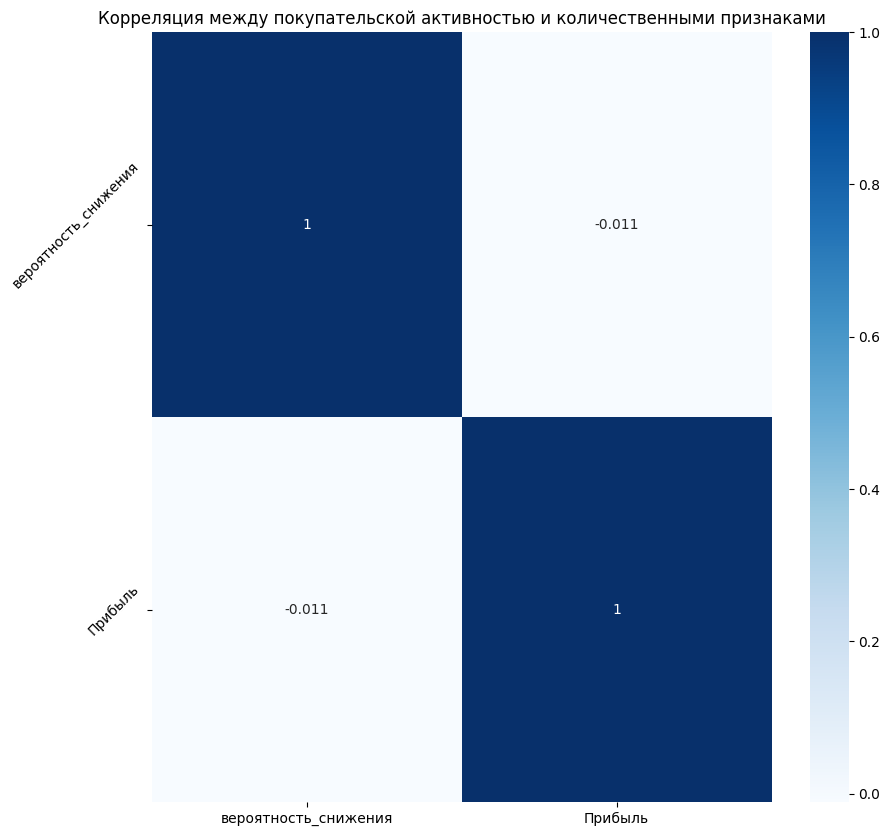

In [76]:
correlation_matrix = segmentation[['вероятность_снижения', 'Прибыль']].corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
plt.yticks(rotation=45)
plt.title(f'Корреляция между покупательской активностью и количественными признаками')
plt.show()

По графику и анализу корреляции можно сделать вывод, что между прибылью от покупателя и вероятностью снижения покупательской активности нет зависимости. Поэтому выберем покупателей, у которых высокая прибыль и высокая вероятность снижения покупательской активности и для них подберем стратегии.

In [77]:
segmentation.describe()

,id,Прибыль,вероятность_снижения
count,1144.000000,1144.000000,1144.000000
mean,216011.445804,4.017465,0.632891
std,376.151461,1.014921,0.370076
min,215349.000000,0.860000,0.001272
25%,215690.750000,3.330000,0.219940
50%,216019.500000,4.070000,0.821678
75%,216341.250000,4.692500,0.946837
max,216647.000000,7.430000,0.997676


In [78]:
segmentation

,id,Прибыль,вероятность_снижения
1,215349,4.16,0.073341
2,215350,3.13,0.497300
4,215352,4.21,0.017477
5,215353,3.95,0.348435
6,215354,3.62,0.160089
...,...,...,...
1295,216643,4.44,0.972605
1296,216644,6.11,0.943924
1297,216645,3.29,0.718724
1298,216646,4.03,0.875315


In [79]:
segmentation['категория'] = 'остальные'
condition = (segmentation['Прибыль'] > 4) & (segmentation['вероятность_снижения'] > 0.7)
segmentation.loc[condition, 'категория'] = 'категория 1'
segmentation = segmentation[segmentation['категория'] != 'остальные']
df_reserch = segmentation.merge(df_merged, on='id', how='inner')
df_reserch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   352 non-null    int64  
 1   Прибыль                              352 non-null    float64
 2   вероятность_снижения                 352 non-null    float64
 3   категория                            352 non-null    object 
 4   Покупательская активность            352 non-null    int64  
 5   Тип сервиса                          352 non-null    object 
 6   Разрешить сообщать                   352 non-null    object 
 7   Маркет_актив_6_мес                   352 non-null    float64
 8   Маркет_актив_тек_мес                 352 non-null    int64  
 9   Длительность                         352 non-null    int64  
 10  Акционные_покупки                    352 non-null    float64
 11  Популярная_категория            

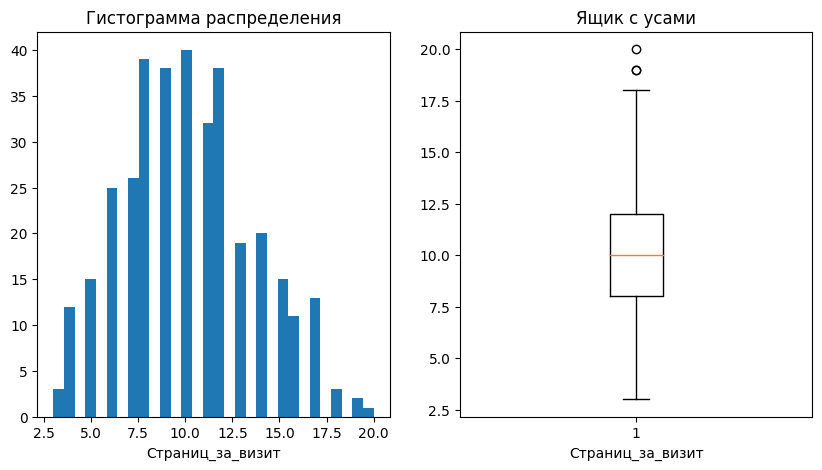

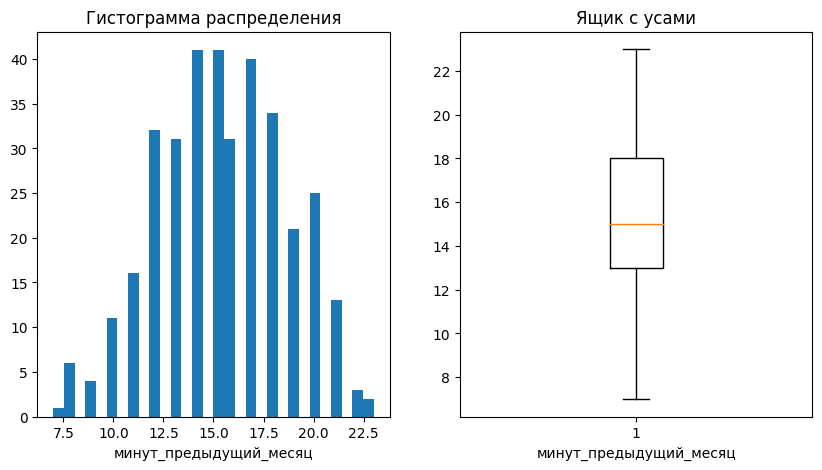

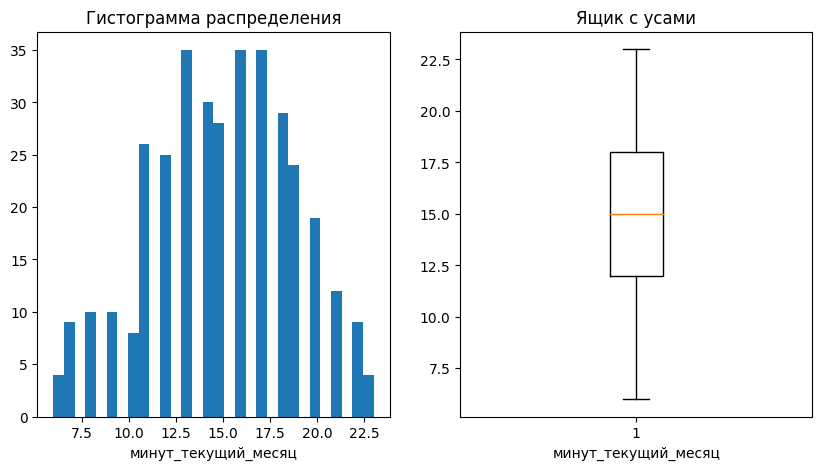

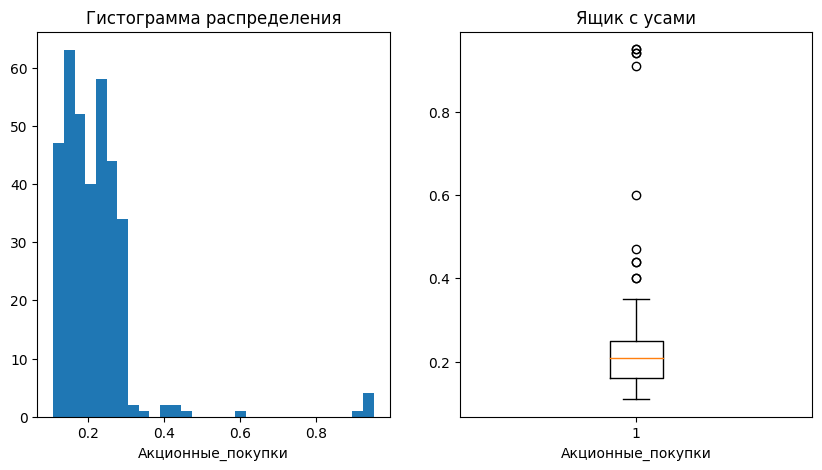

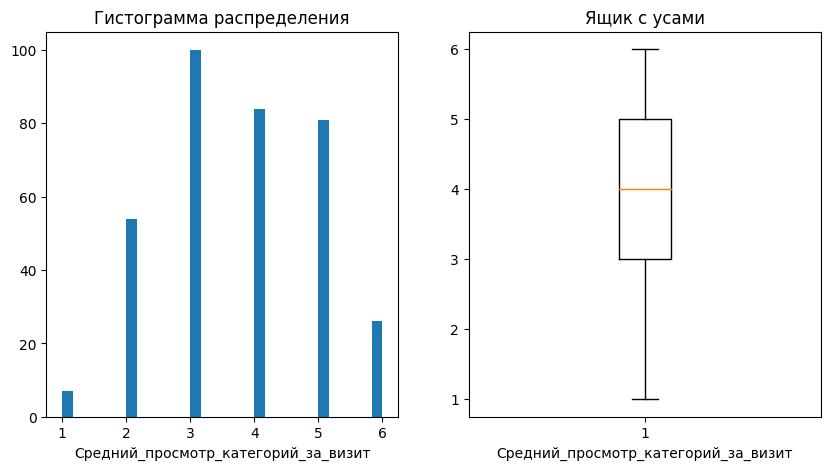

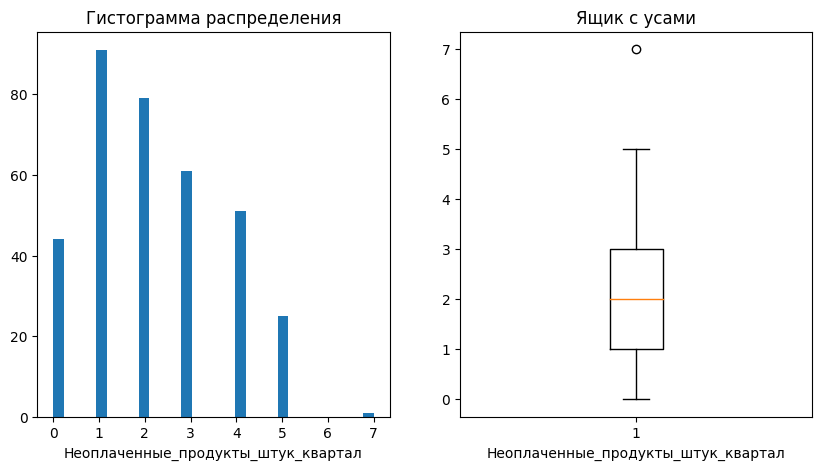

In [80]:
cat_reserch = ['Популярная_категория', 'Разрешить сообщать']
num_reserch = ['Страниц_за_визит', 'минут_предыдущий_месяц', 'минут_текущий_месяц', 'Акционные_покупки',
               'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал']

create_boxplot_and_hist(df_reserch, num_reserch)

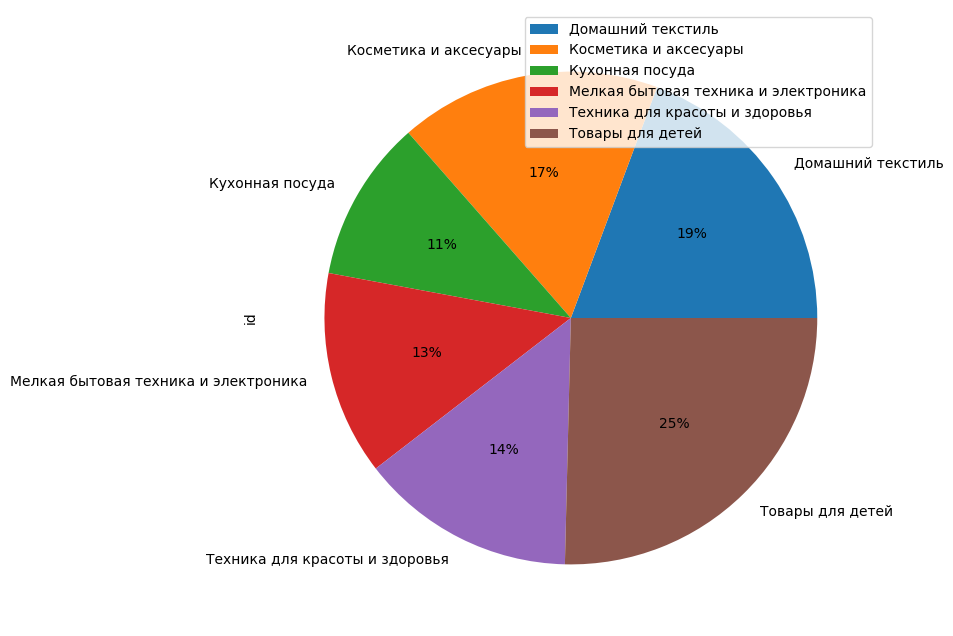

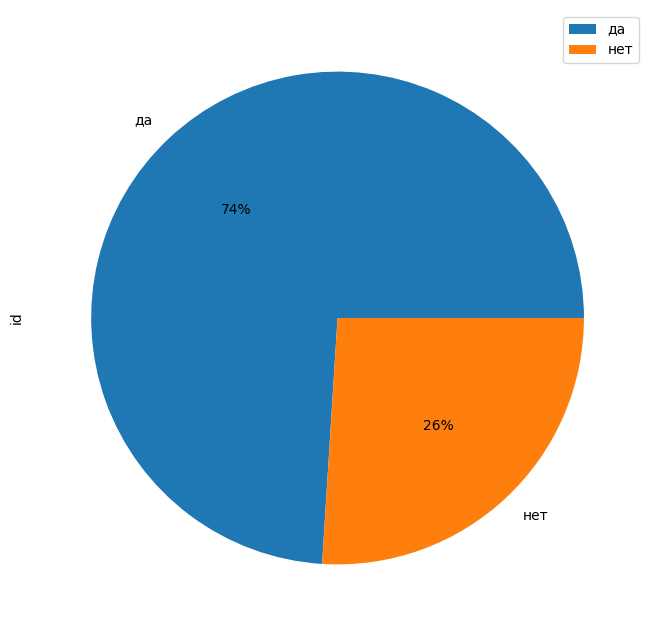

In [81]:
for column in df_reserch[cat_reserch].columns:
    market_file.groupby(column).count().plot(kind='pie', y='id', autopct='%1.0f%%', figsize=(8,8))

**Вывод**


- В качестве целевой аудитории, на которых можно было бы улучшать покупательскую активность - выбрали покупателей с высокой прибылью(от 0.4) и высокой вероятностью снижения активности(выше 70%)
- Таким образом мы видим, что у наших отобранных покупателей самая популярная категория - товары для детей, видно, что акционные покупки пользуются спросом, а у большинства покупателей разрешена рассылка. Из этого можно сделать персональные акции на популярную категорию у каждого покупателя. Либо сезонные акции на детские товары и косметику.
- Также можно ввести на сайт модель, которая бы анализировала посещение пользователя на сайте и их клики. После чего присылать рассылку с подборкой товаров из популярных категорий
- Можно разработать стратегию для неоплаченных покупок. Например, напоминание через рассылку о том, что стоит оплатить покупки. Или с письмом для обратной связи,если возникли проблемы при оплате.

## Заключение

Данные были успешно загружены и проанализированы:
- Пропусков не обнаружено;
- Были удалены дубликаты;

Был проведен статистический анализ каждого ДФ и удалены выбросы

Для поиска лучшей модели выбрали KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC() с гиперпараметрами. Лучшей моделью стала LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear'). Метрика ROC-AUC на тестовой выборке: 0.8761

По анализу важности признаков и выбранных покупателей можно сделать следующие стратегии:

* Можно сделать персональные акции на популярную категорию у каждого покупателя. Либо сезонные акции на детские товары и косметику.
* Предложение ввести на сайт модель, которая бы анализировала посещение пользователя на сайте и их клики. После чего присылать рассылку с подборкой товаров из популярных категорий
* Разработать стратегию для неоплаченных покупок. Например, напоминание через рассылку о том, что стоит оплатить покупки. Или с письмом для обратной связи,если возникли проблемы при оплате.